# Tutorial: Visualising spectra

<br>
<br>

<img style="position: absolute; right: 60px; top: 40px; height: 160px; width: 160px" src="https://datalabs.esa.int/datalab-icon/c11e47af-7ce9-4281-b3b5-475a180a256f" /> 


**Author(s):** Kristin Anett Remmelgas, Héctor Cánovas Cabrera

**Last modified:** 14.03.2025

**Notebook summary**

This notebook demonstrates how to access spectra from the Q1 data volume mounted on ESA Datalabs and visualise these spectra both traditionally with [Matplotlib](https://matplotlib.org/) and optionally using Specviz tool from the interactive [Jdaviz package](https://jdaviz.readthedocs.io/en/latest/index.html). The Jdaviz package is still currently in development so be warned that the second part of the notebook is more on the experimental side. Here is a quick overview of what is covered in the notebook:

1. Using [Euclid Astroquery](https://astroquery--3216.org.readthedocs.build/en/3216/esa/euclid/euclid.html) to query for example sources and their file info
2. Extracting the spectrum of one source from the combined spectra file in the data volume
3. Visualizing the spectrum with Matplotlib
4. Accessing and visualizing multiple spectra
5. Scraping all relevant spectra from the combined spectra files into a single new fits file (like DataLink on archive)
6. Additional: Visualizing spectra interactively with Jdaviz

**Useful links:**

* [Q1 data release homepage](https://www.cosmos.esa.int/en/web/euclid/euclid-q1-data-release)
* [Euclid Q1 data product description](https://euclid.esac.esa.int/dr/q1/dpdd/index.html)
* [Euclid Astroquery documentation](https://astroquery--3216.org.readthedocs.build/en/3216/esa/euclid/euclid.html)
* [Specviz documentation](https://jdaviz.readthedocs.io/en/latest/specviz/index.html)


**Running the notebook:** This notebook has **read-only permissions**. You can still run and edit cells but if you would like to save your changes then you have to save the notebook to a different location - your workspace for example. The notebook is intended to be run using the **EUCLID-TOOLS kernel** that has all the necessary packages included.

***

### Setup

In [1]:
# importing necessary packages
import os
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable
import specutils
from astroquery.esa.euclid.core import EuclidClass
import time

%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

First let's make a folder (if not already created) to save the output files from this notebook. All the example notebooks save their outputs to this same folder in your user workspace called: `'example_notebook_outputs/'`

In [2]:
#make a folder in your workspace for the output files
output_folder = '/media/user/example_notebook_outputs/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

### Choosing archive environment and logging in

Next step is choosing the archive environment you want to work with and logging in. We will be using the PDR environment which stands for "Public Data Release". The code below reads in your Cosmos (Euclid Archive) user credentials from a text file in your workspace (which only you have access to) called cred.txt. This file should contain two lines, one for your username and the second for the password. Once you make this file you can run all the example notebooks without any changes. 

There is also an example of an alternative login method where you put in you username and the cell asks for a password when you run it.

In [3]:
# choosing an archive envionment and logging in
Euclid = EuclidClass(environment='PDR')

# loggin in using a credential file
Euclid.login(credentials_file='/media/user/cred.txt')

# logging in without the credential file
# Euclid.login(user='yourusername') 

INFO: Login to Euclid TAP server: eas.esac.esa.int:443/tap-server/tap/ [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service: eas.esac.esa.int:443/sas-dd/tap-server/ [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service: eas.esac.esa.int:443/sas-cutout/tap-server/ [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


## 1. Query for example sources

In the query below we combine the spectro line features catalog with the spectra_source data table to get some sources with a visible Halpha line and their spectrum file info. The "spectra_source" table tells us for each source the filename and path of the combined spectra file in the volume. This combined spectra file has thousands of spectra as separate fits extensions so the table also gives a hdu_index so we can easily use that to extract the specific spectra we are interested in from the combined file.

The "spectro_line_features_catalog_spe_line_features_cat" contains useful information about the lines potentially present in the spectra, like their (fit) location, signal to noise, or tag name associated to the line. As explained in the "Euclid Quick Data Release (Q1): SPE Processing and Data Products, Euclid Collaboration: Le Brun et al. (2025)" paper (see the list of Q1 related papers in https://www.cosmos.esa.int/en/web/euclid/q1-papers), each line in this table is fit to different redshift solutions by the SPE Processing Function. The best fit corresponds to spe_rank = 0.

In [4]:
# query for sources 

query = """SELECT TOP 10 line_cat.spe_rank, line_cat.spe_line_name, line_cat.spe_line_snr_gf, line_cat.spe_line_snr_di, line_cat.spe_line_central_wl_gf, line_cat.object_id, spec.ra_obj, spec.dec_obj, spec.source_id, spec.file_name, spec.datalabs_path, spec.hdu_index, spec.dith_num
    FROM catalogue.spectro_line_features_catalog_spe_line_features_cat AS line_cat
    JOIN spectra_source AS spec
    ON spec.source_id=line_cat.object_id
    WHERE spe_line_name = 'Halpha' AND spe_line_snr_gf > 10 AND spe_line_snr_di > 10 AND line_cat.spe_rank = 0
    ORDER BY line_cat.object_id ASC"""

job = Euclid.launch_job_async(query)
res = job.get_results()
res

INFO: Query finished. [astroquery.utils.tap.core]


spe_rank,spe_line_name,spe_line_snr_gf,spe_line_snr_di,spe_line_central_wl_gf,object_id,ra_obj,dec_obj,source_id,file_name,datalabs_path,hdu_index,dith_num
int64,str6,float64,float64,float64,int64,float64,float64,int64,str61,str35,int64,int64
0,Halpha,13.431341171264648,11.4399995803833,13408.96484375,-669582376479663828,66.9582376184099,-47.9663828260065,-669582376479663828,EUC_SIR_W-COMBSPEC_102021504_2024-11-01T16:02:56.329745Z.fits,/data/euclid_q1/Q1_R1/SIR/102021504,18,4
0,Halpha,13.503108978271484,11.180000305175781,14556.583984375,-669472851469757226,66.9472851229413,-46.9757226262714,-669472851469757226,EUC_SIR_W-COMBSPEC_102022485_2024-11-01T16:11:44.283501Z.fits,/data/euclid_q1/Q1_R1/SIR/102022485,227,3
0,Halpha,12.604201316833496,11.270000457763672,13014.927734375,-669254451471248090,66.9254451224297,-47.124809027834,-669254451471248090,EUC_SIR_W-COMBSPEC_102022485_2024-11-01T16:07:16.126141Z.fits,/data/euclid_q1/Q1_R1/SIR/102022485,89,4
0,Halpha,14.552885055541992,10.510000228881836,13599.68359375,-669174376469923696,66.9174376085088,-46.9923696758763,-669174376469923696,EUC_SIR_W-COMBSPEC_102022485_2024-11-01T16:08:43.197794Z.fits,/data/euclid_q1/Q1_R1/SIR/102022485,149,4
0,Halpha,14.598451614379883,16.540000915527344,14916.7958984375,-669107222478469763,66.9107222676425,-47.8469763003017,-669107222478469763,EUC_SIR_W-COMBSPEC_102021504_2024-11-01T16:05:06.663216Z.fits,/data/euclid_q1/Q1_R1/SIR/102021504,247,4
0,Halpha,13.107318878173828,11.779999732971191,14898.966796875,-668627133478605271,66.8627133033216,-47.8605271281211,-668627133478605271,EUC_SIR_W-COMBSPEC_102021504_2024-11-01T16:04:47.148990Z.fits,/data/euclid_q1/Q1_R1/SIR/102021504,319,4
0,Halpha,20.060518264770508,12.800000190734863,13638.0966796875,-668385613475065212,66.8385613052256,-47.5065212115996,-668385613475065212,EUC_SIR_W-COMBSPEC_102021992_2024-11-05T15:26:54.050974Z.fits,/data/euclid_q1/Q1_R1/SIR/102021992,757,4
0,Halpha,16.62991714477539,11.199999809265137,16038.5615234375,-668246070474298938,66.8246070493962,-47.4298938602133,-668246070474298938,EUC_SIR_W-COMBSPEC_102021992_2024-11-05T15:28:02.628961Z.fits,/data/euclid_q1/Q1_R1/SIR/102021992,603,5
0,Halpha,13.140656471252441,11.680000305175781,16242.87109375,-668080948471157063,66.8080948203427,-47.1157063574119,-668080948471157063,EUC_SIR_W-COMBSPEC_102022485_2024-11-01T16:07:21.678544Z.fits,/data/euclid_q1/Q1_R1/SIR/102022485,534,4


## 2. Extracting the spectrum of one source from the combined spectra file in the data volume
### Looking at a combined spectra file in the volume

Firstly to get a better understanding of what we are working with we can take a closer look at one of the combined spectra files in the volume. We will take a look at the file corresponding to the source with object_id -669107222478469763 (with index 4 in the tabel above). As you can see after running the cell there are over 9000 extensions in the FITS file. For each source there is first a meta HDU then the combined signal of all the dither frames (the data we are mostly interested in) and after that the signal and contaminants data for each of the dithers separately.

PS: By clicking on the cell below and then the blue sidebar next to the output you can hide the output of the cell so you don't have to scroll all the way through.

In [5]:
# accessing source filepath by source_id
source4_info = res[res["object_id"] == -669107222478469763]
source4_filepath = source4_info["datalabs_path"][0] + '/' + source4_info["file_name"][0]

# accessing source filepath directly by indexing the result table
# source4_filepath = res[4]["datalabs_path"] + '/' + res[4]["file_name"] 

hdul = fits.open(source4_filepath)
print(fits.info(source4_filepath))

Filename: /data/euclid_q1/Q1_R1/SIR/102021504/EUC_SIR_W-COMBSPEC_102021504_2024-11-01T16:05:06.663216Z.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   ()      
  1  0_META        1 ImageHDU        10   ()      
  2  1_META        1 ImageHDU        10   ()      
  3  1_COMBINED1D_SIGNAL    1 BinTableHDU     34   531R x 6C   [1E, 1E, 1J, 1E, 1E, 1I]   
  4  1_DITH1D_15887_SIGNAL    1 BinTableHDU     36   531R x 5C   [1E, 1E, 1J, 1E, 1E]   
  5  1_DITH1D_15887_CONTAMINANTS    1 BinTableHDU     16   2R x 1C   [1K]   
  6  1_DITH1D_15888_SIGNAL    1 BinTableHDU     36   531R x 5C   [1E, 1E, 1J, 1E, 1E]   
  7  1_DITH1D_15888_CONTAMINANTS    1 BinTableHDU     16   1R x 1C   [1K]   
  8  1_DITH1D_15889_SIGNAL    1 BinTableHDU     36   531R x 5C   [1E, 1E, 1J, 1E, 1E]   
  9  1_DITH1D_15889_CONTAMINANTS    1 BinTableHDU     16   2R x 1C   [1K]   
 10  1_DITH1D_15890_SIGNAL    1 BinTableHDU     36   531R x 5C   [1E, 1E, 1J, 1E, 1E]   

### Getting the spectrum for one of the sources

Now we can also take a closer look at the data in one of the extensions, again corresponding to the source with index 4 in the table above. We are using astropy.io.fits to access both the data and header of the extension and then taking a look at the columns available in the data table as well as the header structure.

In [6]:
source4_ext = source4_info["hdu_index"][0]
source4_specdata = hdul[source4_ext].data
source4_header = hdul[source4_ext].header

print("Table columns", source4_specdata.columns.names)
source4_header

Table columns ['WAVELENGTH', 'SIGNAL', 'MASK', 'QUALITY', 'VAR', 'NDITH']


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   22 / width of table in bytes                        
NAXIS2  =                  531 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    6 / number of fields in each row                   
TTYPE1  = 'WAVELENGTH'         / label for field   1                            
TFORM1  = '1E      '           / data format of field: 4-byte REAL              
TUNIT1  = 'Angstrom'           / physical unit of field                         
TTYPE2  = 'SIGNAL  '           / label for field   2                            
TFORM2  = '1E      '        

## 3. Visualizing the spectrum with Matplotlib

This is how you could visualize the spectrum using Matplotlib. We also use the `spe_line_central_wl_gf` column form the table above to mark the spectral line location with a red line. 

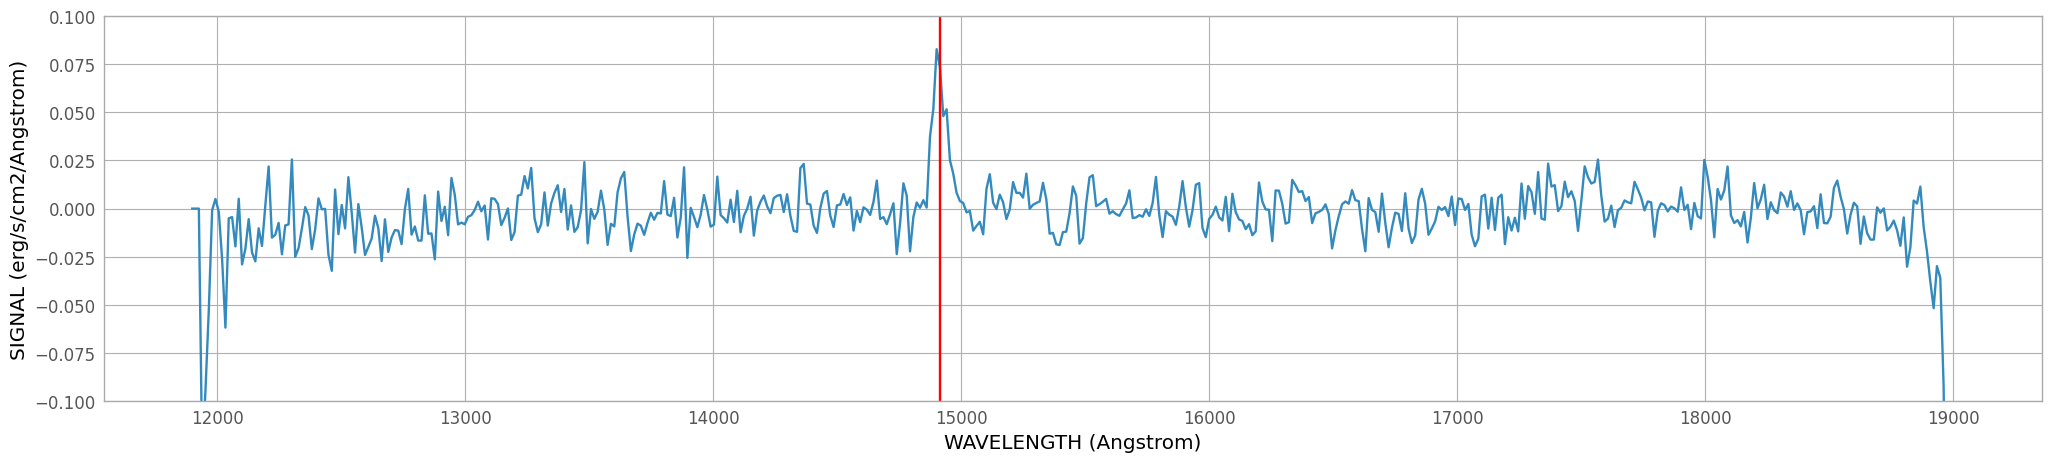

In [7]:
fig = plt.figure(figsize= [25,5])
ax = plt.axes()
ax.plot(source4_specdata.field('WAVELENGTH'), source4_specdata.field('SIGNAL'))
ax.vlines(x=source4_info['spe_line_central_wl_gf'], ymin = -0.5, ymax = 0.1, color = 'red', label = 'spe_line_central_wl_gf')
plt.ylim([-0.1, 0.1])
plt.xlabel(f"WAVELENGTH ({source4_header['TUNIT1']})")
plt.ylabel(f"SIGNAL ({source4_header['TUNIT2']})");

## 4. Accessing and visualizing multiple spectra

Below is an example of how to create a grid of 3 by 3 spectra visualizations with Matplotlib for the first 9 sources in our source table. Note that the title of each graph is the source id.

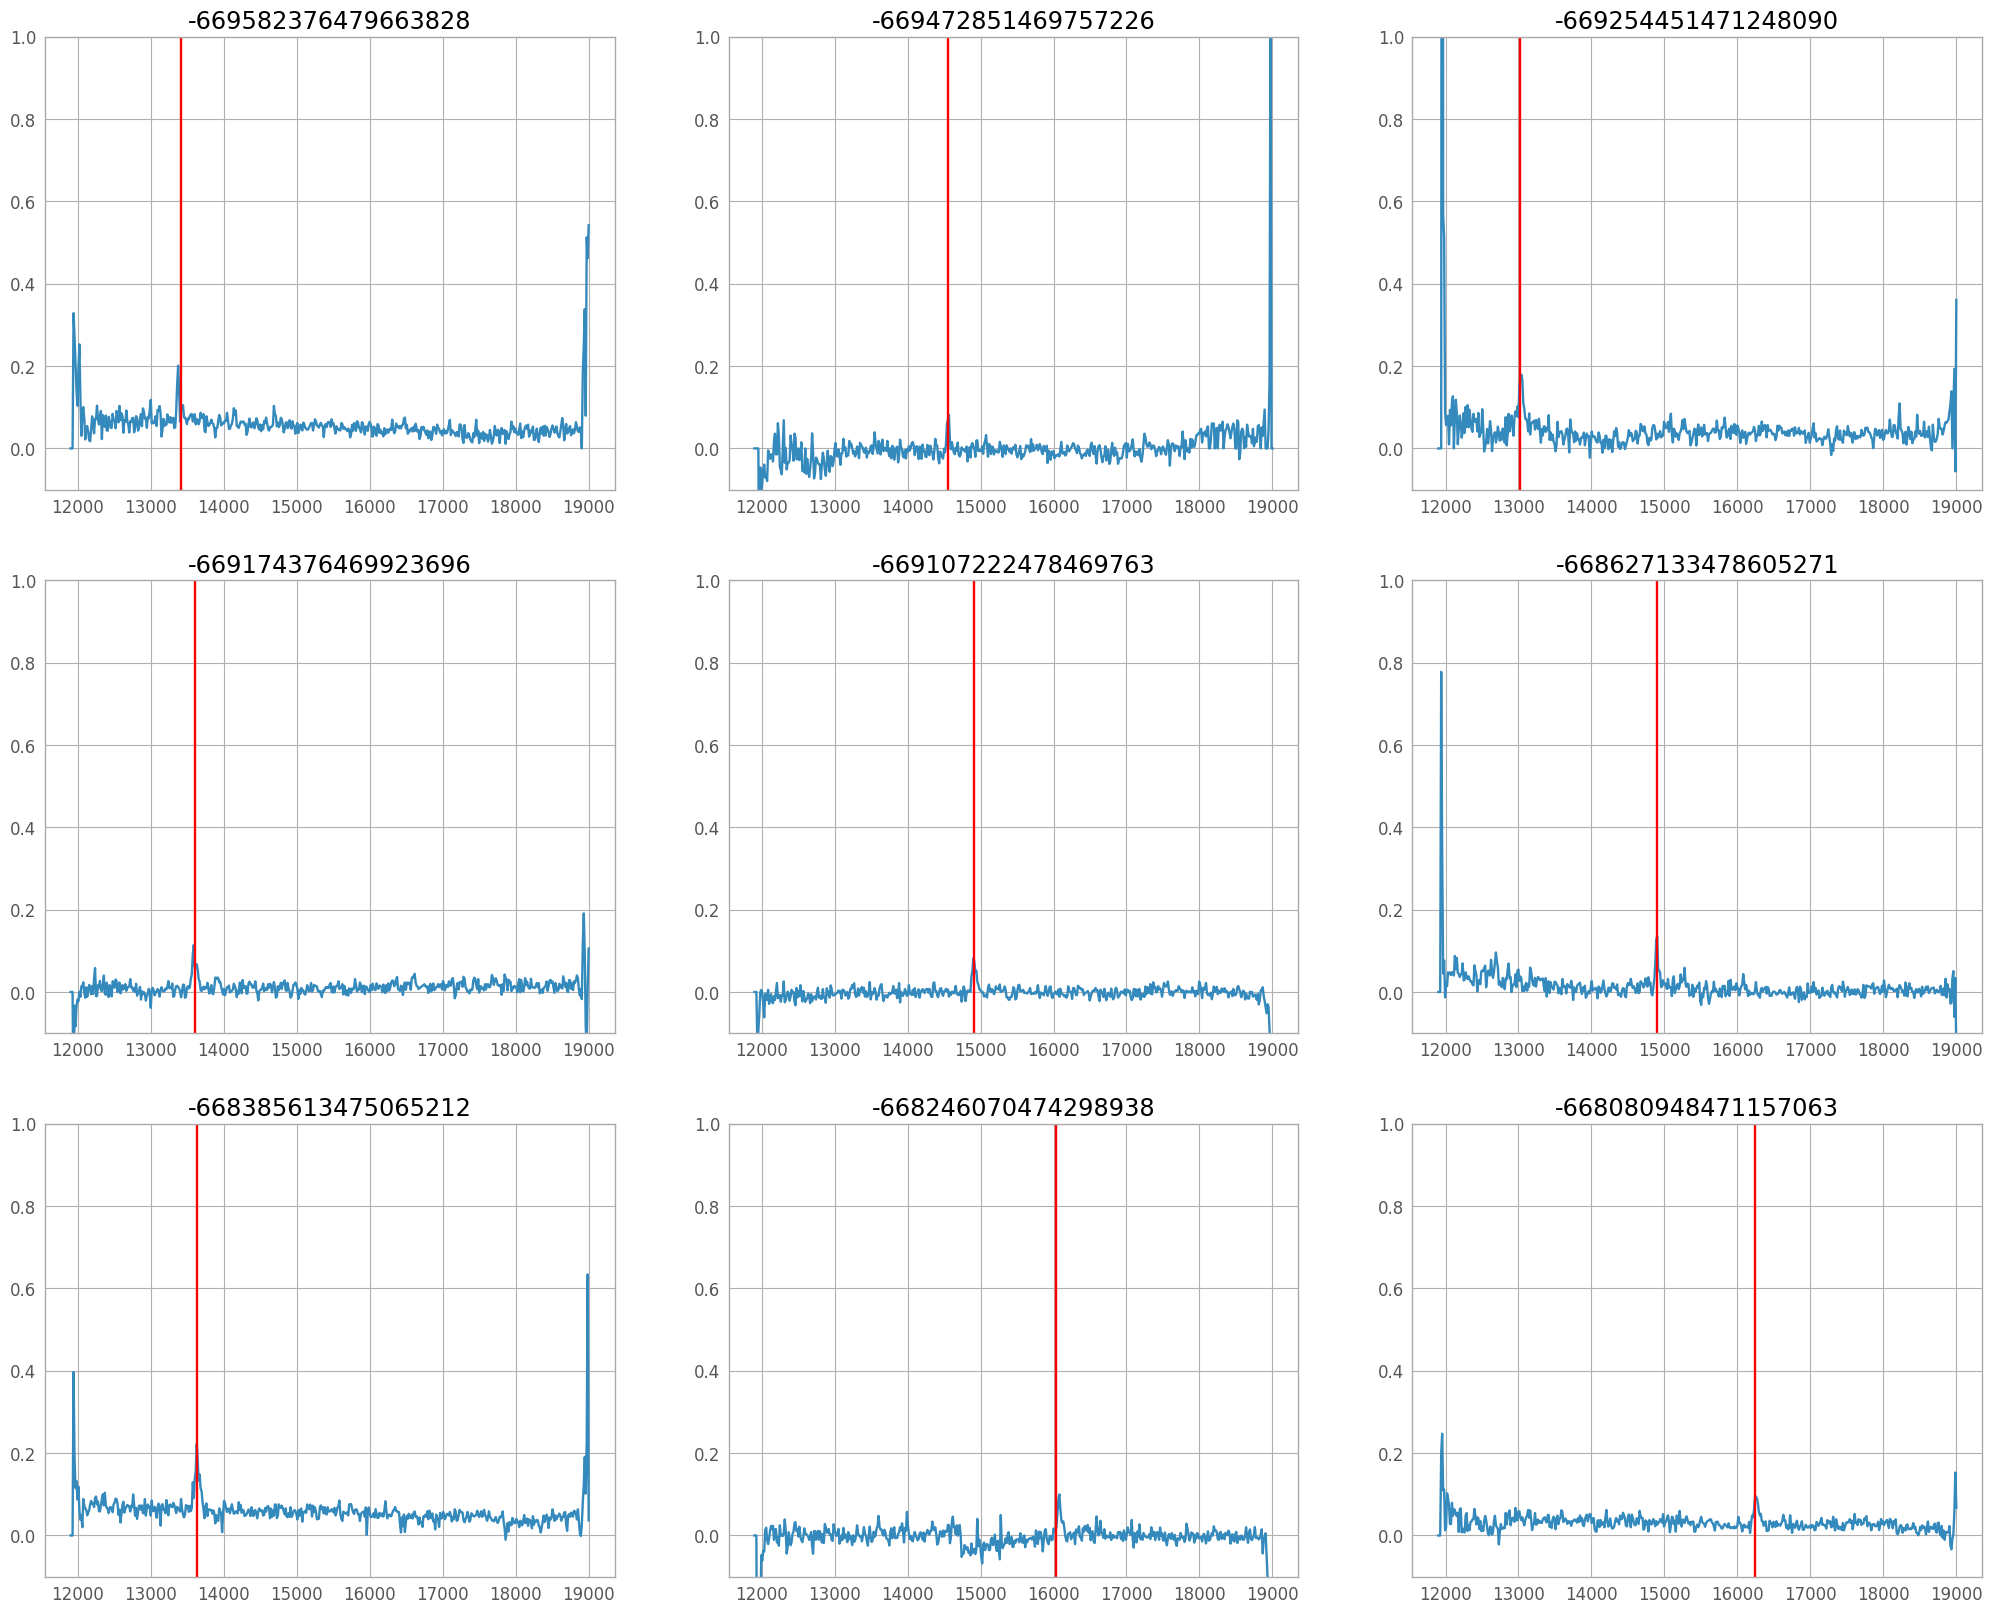

In [8]:
_, axes = plt.subplots(3, 3, figsize=(25, 20))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for ax, source in zip(axes.flatten(), res[:9]):
    spectra_data = fits.getdata(source["datalabs_path"] + '/' + source["file_name"], ext=source["hdu_index"])
    ax.plot(spectra_data.field('WAVELENGTH'), spectra_data.field('SIGNAL'))
    ax.vlines(x=source['spe_line_central_wl_gf'], ymin = -0.1, ymax = 1.0, color = 'red', label = 'spe_line_central_wl_gf')
    ax.set_ylim([-0.1, 1.0])
    ax.title.set_text(source['source_id'])

## 5. Scraping all relevant spectra from the combined spectra files into a single new FITS file

The cell below shows how to make a new FITS file containing only the spectra for the sources in the source table. So for each source we find the combined spectra file in the volume, extract the correct extension and add it to a new FITS file. This is similar to what is possible on the archive website using DataLink.

In [9]:
primary_hdu = fits.PrimaryHDU()
hdul_new = fits.HDUList([primary_hdu])

for source in res[:10]:
    hdul_big = fits.open(source["datalabs_path"] + '/' + source["file_name"])
    hdu = hdul_big[source["hdu_index"]]
    hdu.name = str(source['source_id'])
    hdul_new.append(hdu)

hdul_new.writeto(output_folder + 'MY_SPECTRA.fits', overwrite=True)

In [10]:
#checking the content of the new fits file
hdul_test = fits.open(output_folder + "./MY_SPECTRA.fits")
print(fits.info(output_folder + "./MY_SPECTRA.fits"))

Filename: /media/user/example_notebook_outputs/./MY_SPECTRA.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  -669582376479663828    1 BinTableHDU     34   531R x 6C   [1E, 1E, 1J, 1E, 1E, 1I]   
  2  -669472851469757226    1 BinTableHDU     34   531R x 6C   [1E, 1E, 1J, 1E, 1E, 1I]   
  3  -669254451471248090    1 BinTableHDU     34   531R x 6C   [1E, 1E, 1J, 1E, 1E, 1I]   
  4  -669174376469923696    1 BinTableHDU     34   531R x 6C   [1E, 1E, 1J, 1E, 1E, 1I]   
  5  -669107222478469763    1 BinTableHDU     34   531R x 6C   [1E, 1E, 1J, 1E, 1E, 1I]   
  6  -668627133478605271    1 BinTableHDU     34   531R x 6C   [1E, 1E, 1J, 1E, 1E, 1I]   
  7  -668385613475065212    1 BinTableHDU     34   531R x 6C   [1E, 1E, 1J, 1E, 1E, 1I]   
  8  -668246070474298938    1 BinTableHDU     34   531R x 6C   [1E, 1E, 1J, 1E, 1E, 1I]   
  9  -668080948471157063    1 BinTableHDU     34   531R x 6C   [1E, 1E, 1J, 1E, 1E, 1I]   
 10

## 6. Jdaviz package - Specviz interactive visualization

Here is an example of how to visualize the same spectrum interactively using Jdaviz Specviz. Specviz is a tool for visualization and quick-look analysis of 1D astronomical spectra (there is also Specviz2D for 2D spectra). It supports:

* flexible spectral unit conversions, custom plotting attributes, interactive selections, multiple plots, and other features
* includes a measurement tool for spectral lines which enables the user, with a few mouse actions, to perform and record measurements. 
* model fitting capability that enables the user to create simple (e.g., single Gaussian) or multi-component models (e.g., multiple Gaussians for emission and absorption lines in addition to regions of flat continua). 
* everything that can be done in the visual interface window can also be done using Python commands. 
* the contents of the viewer or a plot within the plugin can be exported to various image formats. Additionally, spatial and spectral regions can be exported to files.

You can find extensive guides, documentation and examples on how to use Specviz here: https://jdaviz.readthedocs.io/en/latest/specviz/index.html

**Disclaimer**

1. Jdaviz package is in active development so some bugs may occur. 
2. Keep in mind that the aim of this notebook is to demonstrate the functinalities that are available and how to use them, not to necessarily provide a 100% valid scientific use case.

### Creating empty Specviz window

In the following cell we create a Specviz instance and show the (for now) empty window. The viewer can be displayed either in the output of the cell below or alternatively on the side of the notebook (especially helpful when you have a wider screen). Note that everything we do in the code cells beyond this point will update this same display and can also be done by using the buttons in the user interface. Since we are updating the same display please run the cells below one at a time (not "run all"). This way you can look at the viewer after each cell to see the changes and we also make sure that the previous command is completed before sending a new one to Specviz.

In [11]:
from jdaviz import Specviz
from specutils import Spectrum1D
import warnings

# Suppress warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")

specviz = Specviz()
viewer = specviz.app.get_viewer('spectrum-viewer')

# showing the viewer embedded into this notebook
specviz.show()

# showing the viewer on the side of the notebook
# specviz.show('sidecar', height=1000)

<IPython.core.display.Javascript object>

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v4.1.1/specviz/index.html', events=[…

### Loading spectra data

With the cell below we load the spectrum data into the Specviz viewer. This can be done in the interface by using the blue "import data" button at the top left of the viewer. Even though we can tell Specviz exactly which extension to access the loading process still takes a while when the file is large. Below are two examples for loading the file, one from the big combined spectra file and one from the smaller file we scraped together before which is a lot faster. 

Jdaviz doesn't like how the units are defined in the spectra file and will give a lot of warnings about it even though the spectra is loaded correctly. This is why we ignore warnings when loading the data in the cell below.

In [12]:
# loading spectrum from our small file of sources - faster
source4_ext = hdul_test.index_of("-669107222478469763")
source4_filepath = output_folder + "./MY_SPECTRA.fits"

# loading same spectrum from the big combined spectra file (like before) - takes longer
# source4_info = res[res["object_id"] == -669107222478469763]
# source4_ext = source4_info['hdu_index'][0]
# source4_filepath = source4_info["datalabs_path"][0] + '/' + source4_info["file_name"][0]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    spec1d = Spectrum1D.read(source4_filepath, hdu=source4_ext, store_data_header=False) 
    specviz.load_data(spec1d)

### Changing basic plot options

With the data loaded we can now try to change some basic plot options like line color, width and opacity.

In [13]:
# basic plot options
plot_options = specviz.plugins['Plot Options']
plot_options.line_color = 'green'
plot_options.line_width = 2
plot_options.line_opacity = 0.8
# plot_options.uncertainty_visible = True

### Zoom to region

It is also possible to programmatically set axis limits for the viewer resulting in a zoom to that area. To do this in the viewer you can click the button to "zoom to a drawn rectangle" and select the area by click-dragging with your mouse. To reset the zoom click the home button.

In [14]:
# setting axis limits
viewer.set_limits(x_min=14200, x_max=15800, y_min=-0.04, y_max=0.1)

# resetting to default
# viewer.reset_limits()

### Defining spectral regions

To create a spectral region subset in the viewer, click the button for selecting a range of x values (next to the zoom and pan buttons) and click-drag on the image to create the subset. In the cell below we also show how to create regions programmatically and look at how to export regions from the viewer.

In [15]:
# creating subset/region manually
plugin_subset = specviz.plugins['Subset Tools']
line_region = specutils.SpectralRegion(14794.48277265176*u.angstrom, 15086.436795640266*u.angstrom)
plugin_subset.import_region([line_region])

In [16]:
# check all regions that have been created
reg = plugin_subset.get_regions()
reg

{'Subset 1': Spectral Region, 1 sub-regions:
   (14794.48277265176 Angstrom, 15086.436795640266 Angstrom) }

### Model fitting

The "Model fitting" section in the main menu of the viewer enables Astropy models to be fit to the spectrum. You can first select the part of the spectrum to fit to, then add some model components: we add a constant and Gaussian component. Then you can choose how the components are combined and calculate the fit. After that the fit is added as a line called "model" to the viewer and you can modify the visual options for the line and export the parameters of your fitted model.

In [17]:
# Open model fitting plugin
plugin_mf = specviz.plugins['Model Fitting']

# Input the appropriate dataset and subset
plugin_mf.dataset = 'Spectrum1D'
plugin_mf.spectral_subset = 'Subset 1'

# Input the model components
plugin_mf.create_model_component(model_component='Const1D', model_component_label='C')
plugin_mf.create_model_component(model_component='Gaussian1D', model_component_label='G')

# Set the initial guess of some model parameters
# plugin_mf.set_model_component('G', 'stddev', 0.002)
# plugin_mf.set_model_component('G', 'mean', 2.2729)

# Model equation gets populated automatically, but can be overwritten
plugin_mf.equation = 'C+G'

# Calculate fit
mod = plugin_mf.calculate_fit()

In [18]:
# modify model line options separately to see it better
plot_options.layer = 'model'
plot_options.line_width = 2

In [19]:
# exporting model parameters
table = plugin_mf.export_table()
table

model,data_label,spectral_subset,equation,C:amplitude_0,C:amplitude_0:unit,C:amplitude_0:fixed,C:amplitude_0:std,G:amplitude_1,G:amplitude_1:unit,G:amplitude_1:fixed,G:amplitude_1:std,G:mean_1,G:mean_1:unit,G:mean_1:fixed,G:mean_1:std,G:stddev_1,G:stddev_1:unit,G:stddev_1:fixed,G:stddev_1:std
str5,str10,str8,str3,float64,str22,bool,float64,float64,str22,bool,float64,float64,str8,bool,float64,float64,str8,bool,float64
model,Spectrum1D,Subset 1,C+G,-0.0030815954590804693,erg / (Angstrom s cm2),False,0.0026109810193332772,0.07730596131637699,erg / (Angstrom s cm2),False,0.005096450803840016,14912.45044360124,Angstrom,False,2.168220179466124,30.56437474132568,Angstrom,False,2.610264415173159


### Loading an available line list

In the viewer "Line lists" section of the main menu it is possible to load a variety of available line lists. Notice that simply loading a line list is not enough to make the lines appear in the viewer. After loading the lines, users can open the dropdown and select the visibility of each line separately. This can also be seen below where we first load the line list and then take a look at the lines table where we see that the show column value is 0 for all of them at first. We can then plot a specific line from that table by name like we do with the H alpha line which will change the value of the show field to 1.

In [20]:
#Taking a look at available line lists
specviz.available_linelists

['Galactic 700A-2000A',
 'Galactic 2000A-11000A',
 'Atomic/Ionic Fine Structure',
 'SDSS',
 'SDSS-IV',
 'H-Paschen-Brackett',
 'H2',
 'H2-ISO',
 'CO',
 'CO-band-heads',
 'UV Galactic']

In [21]:
# loading one of them (won't show in viewer yet)
specviz.load_line_list('Galactic 2000A-11000A')

In [22]:
# taking a look at the lines in the list
current_lines = specviz.spectral_lines
current_lines

linename,rest,listname,show,name_rest,colors
,Angstrom,,,,
str9,float64,str21,int64,object,str9
N II],2142.78,Galactic 2000A-11000A,0,N II] 2142.78,#FF0000FF
[O III],2320.951,Galactic 2000A-11000A,0,[O III] 2320.951,#FF0000FF
C II],2323.5,Galactic 2000A-11000A,0,C II] 2323.5,#FF0000FF
C II],2324.69,Galactic 2000A-11000A,0,C II] 2324.69,#FF0000FF
[Fe XI],2648.71,Galactic 2000A-11000A,0,[Fe XI] 2648.71,#FF0000FF
He II,2733.289,Galactic 2000A-11000A,0,He II 2733.289,#FF0000FF
[Mg V],2782.7,Galactic 2000A-11000A,0,[Mg V] 2782.7,#FF0000FF
Mg II],2795.528,Galactic 2000A-11000A,0,Mg II] 2795.528,#FF0000FF


In [23]:
# plotting H alpha line in viewer
specviz.plot_spectral_line(line='H a')

# you can also include a redshift manually
# specviz.plot_spectral_line(line='H a', global_redshift=10)

### Importing custom line lists

It is also possible for the user to create and load their own list of lines which we demonstrate below. First we load our line list and then show the table of lines again. Notice how the length of the resulting table increased by 2 to include our custom lines. These custom lines will also be shown in the viewer automatically.

In [24]:
my_line_list = QTable()
my_line_list['linename'] = ['Line1','Line2']
my_line_list['rest'] = [1500, 1600]*u.nm
specviz.load_line_list(my_line_list)

# Show all imported lines
current_lines = specviz.spectral_lines
current_lines

linename,rest,listname,show,name_rest,colors
,nm,,,,
str9,float64,str21,int64,object,str9
Ar I,786.8194000000001,Galactic 2000A-11000A,0,Ar I 7868.194,#FF0000FF
C II,723.642,Galactic 2000A-11000A,0,C II 7236.42,#FF0000FF
C III,464.742,Galactic 2000A-11000A,0,C III 4647.42,#FF0000FF
C III,465.02500000000003,Galactic 2000A-11000A,0,C III 4650.25,#FF0000FF
C III,465.14700000000005,Galactic 2000A-11000A,0,C III 4651.47,#FF0000FF
C III,569.592,Galactic 2000A-11000A,0,C III 5695.92,#FF0000FF
C II],232.35000000000002,Galactic 2000A-11000A,0,C II] 2323.5,#FF0000FF
C II],232.46900000000002,Galactic 2000A-11000A,0,C II] 2324.69,#FF0000FF


In [25]:
# removing the custom spectral lines again using the name_rest value in the table
line1_name_rest = current_lines[current_lines['linename']=='Line1']['name_rest'][0]
line2_name_rest = current_lines[current_lines['linename']=='Line2']['name_rest'][0]
viewer.erase_spectral_lines(name_rest=line1_name_rest)
viewer.erase_spectral_lines(name_rest=line2_name_rest)

# option for removing all spectral lines
# specviz.erase_spectral_lines()

### Unit conversions

Under the "Unit conversion" section in the viewer it is possible to convert the units of both axis in the viewer. This choice affects the default units in all viewers and plugins, where applicable, but does not affect the underlying data. After doing this you may need to reset the zoom again.

In [26]:
plugin_unitconv = specviz.plugins['Unit Conversion']
plugin_unitconv.spectral_unit = 'nm'
# plugin_unitconv.flux_unit = 'mJy'

viewer.reset_limits()

### Line analysis

The Line Analysis plugin returns Specutils analysis for a single spectral line. The properties returned include the line centroid, Gaussian sigma width, gaussian FWHM, total flux, and equivalent width. You can read more about the analysis in the [line analysis plugin documentation](https://jdaviz.readthedocs.io/en/latest/specviz/plugins.html#line-analysis) or [specutils documentation](https://specutils.readthedocs.io/en/stable/analysis.html).

Note: If the result of the cell comes out empty it helps to click somewhere in the viewer and then run the below cell again.

In [29]:
# input the appropriate spectrum and region
plugin_la = specviz.plugins['Line Analysis']
plugin_la.open_in_tray()

plugin_la.dataset = 'Spectrum1D'
plugin_la.spectral_subset = 'Subset 1'

# possible to include the value for the continuum default is Surrounding
# plugin_la.continuum = 'Subset 3'

# return line analysis results
la_res = plugin_la.get_results()
la_res

[{'function': 'Line Flux',
  'result': '0.004700109901679715',
  'uncertainty': '',
  'unit': 'W / m2'},
 {'function': 'Equivalent Width',
  'result': '',
  'error_msg': 'N/A (continuum <= 0)',
  'uncertainty': '',
  'unit': ''},
 {'function': 'Gaussian Sigma Width',
  'result': '4.959136461248604',
  'uncertainty': '',
  'unit': 'nm'},
 {'function': 'Gaussian FWHM',
  'result': '11.67787394499206',
  'uncertainty': '',
  'unit': 'nm'},
 {'function': 'Centroid',
  'result': '1489.807040548465',
  'uncertainty': '',
  'unit': 'nm'}]

### Finding the redshift

Assuming the feature in the spectra is the hydrogen alpha line we can use the centroid value from the line analysis and calculate the redshift of the source. The redshift value can also be found in the Line Analysis section of the viewer and can be applied to the H alpha line to move it to the location of the feature in our spectrum by clicking the assign button. Below we calculate the redshift by using the formula: $z = \frac{\lambda_{observed}}{\lambda_{emitted}} -1 $ 

It is important to double check that the units match before doing this. The cell below depends on the previous cell having run successfully if the values above are empty then try to run that cell again and then this one.

In [30]:
observed = float(la_res[-1]['result'])
emitted = current_lines[current_lines['linename']=='H a']['rest'].value[0]

z = (observed / emitted) -1 
print("Source redshift is:", round(z, 4))

Source redshift is: 1.2701


***

**Runnning the notebook outside of Datalabs**

The current notebook was developed with the intent to use it inside ESA Datalabs, so all the filepaths point to the data volume mounted in ESA Datalabs for direct data access. It is possible to modify the notebook to run outside of the platform if needed, but there are a few things to consider:

1. You need to install all the packages used in the notebook yourself
2. When trying to access any of the data, the products first need to be downloaded from the archive for example by using Astroquery (due to the files being large this might take some time which is why using ESA Datalabs is advised)

You can download the spectra by using the Astroquery get_spectrum method as shown below. After downloading the spectra you can run the rest of the notebook by substituting the ESA Datalabs file path(s) set in the notebook with the one(s) you set on you local machine. More information about using the function below can be found in the [Astroquery examples notebook](Astroquery.ipynb).

`source_id = res[0]['object_id']`

`Euclid.get_spectrum(source_id = str(source_id), retrieval_type = "SPECTRA_RGS", output_file=output_folder + 'local_file_name.fits.zip')`